In [1]:
import numpy as np
from numpy import linalg as lin
import random as rn
from pyvis.network import Network
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import triad_utils as tu

In [3]:
# UNIX
! rm net_names.txt
#v1) ! ls database >> net_names.txt
! ls matrices >> net_names.txt

In [4]:
file = open('net_names.txt')
net_names = [name.rstrip() for name in file]

In [5]:
len(net_names)

71

In [6]:
census = []
for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = tu.triad_census(matrix)
    census.append(list(t))
    
df1 = pd.DataFrame(census)
df1.columns = ['t'+str(i) for i in range(1,14)]
df1.to_csv('triads_count.csv')

In [ ]:
df1 = pd.read_csv('triads_count.csv').drop('Unnamed: 0', axis=1)

In [7]:
df1.head()

,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13
0,33,31,87,10,18,0,8,1,0,1,2,0,1
1,47,34,53,18,20,3,51,4,1,6,12,5,0
2,123,85,180,22,26,2,38,3,3,0,7,0,0
3,9,12,25,13,6,2,1,0,2,2,1,3,1
4,36,44,68,12,8,0,2,1,0,0,0,0,0


In [8]:
norm_df1 = df1.div(df1.sum(axis=1), axis=0) 

## Triad Concentration Profiles
As in Milo Supplementary Information pag. 2

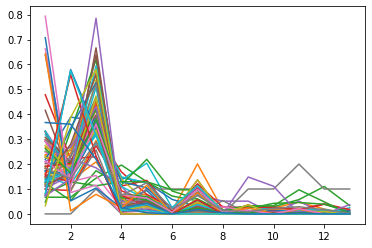

In [9]:
for i in range(len(norm_df1)):
    pr = norm_df1.loc[i]
    t = np.arange(1,14)
    plt.plot(t,pr)

In [10]:
# K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [11]:
X = norm_df1

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 11)]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

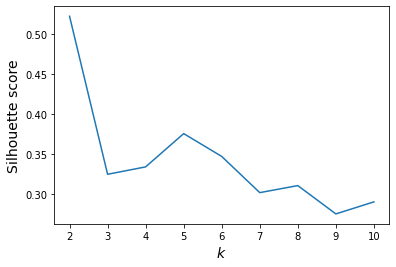

In [12]:
#plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.xticks(np.arange(2, 11, step=1))
plt.savefig('figures/silhouette.pdf')
plt.show()

In [13]:
k = 2
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(norm_df1)

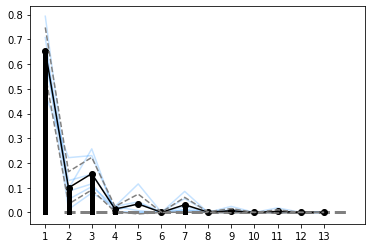

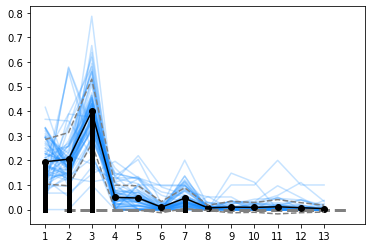

In [14]:
t = np.arange(0,13)
for y in np.unique(y_pred):
    selected_data = []
    for i in range(len(norm_df1)):
        if y_pred[i] == y:
            sp = np.array(norm_df1.iloc[i])
            selected_data.append(sp)
            plt.plot(t,sp,alpha=.25, c = 'dodgerblue')
    m = np.mean(np.array(selected_data),axis=0)
    s = np.std(np.array(selected_data),axis=0)
        
    plt.plot([0.8,13.1],[0,0],'--',c='gray',linewidth=3)
    
    plt.plot(t,m,'k')
    plt.plot(t,m,'ok')
    plt.plot(t,m+s,'--',c='gray')
    plt.plot(t,m-s,'--',c='gray')

    for k in range(13):
        if 0 <= m[k] - s[k] or 0>= m[k] + s[k]:
            plt.plot([k,k],[0,m[k]], c = 'k' ,linewidth=5)
    
    plt.xticks(np.arange(13), [str(i) for i in range(1,14)])
    
#    plt.title('macro-family #'+str(y))
    plt.savefig('figures/concentration_profile_'+str(y)+'.pdf')
    plt.show()

In [15]:
data = [ list(norm_df1['t'+str(i+1)]) for i in range(13) ]

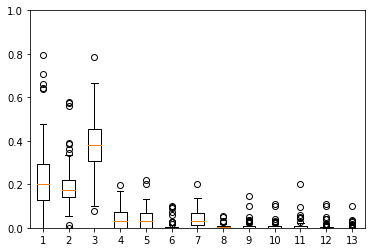

In [16]:
plt.boxplot(data,notch=False)
plt.ylim(0,1);

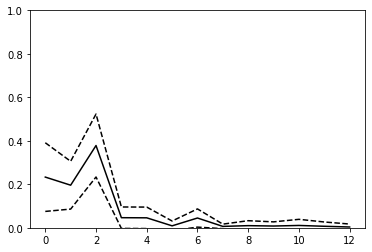

In [17]:
m = norm_df1.mean()
s = norm_df1.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')
plt.ylim(0,1);

In [18]:
df1.mean(axis=1,numeric_only=True)

0     14.769231
1     19.538462
2     37.615385
3      5.923077
4     13.153846
        ...    
66    10.923077
67    74.538462
68     2.384615
69     5.615385
70    34.384615
Length: 71, dtype: float64

# Triad Significance Profiles

Milo sets the triad count to zero if $N_i<2$ (Supp Info pag. 1). I need to correct the function for the triad count introducing a threshold. For now, I'm applying a filter after I calculate the census. I'm setting the count to zero if less than 1% of the total. This probably cuts a lot more than Milo did.

In [19]:
def filter_census(census):
    N_tot = sum(census)
    for i in range(13):
#       if census[i] < N_tot/100:
        if census[i] < 2:
            census[i] = 0
    return census

def triad_significance_profile_with_filter(matrix, ensemble_size, edge_randomizations):
# assumptions: no self-loops, all weights = 1

    ensemble = []
    
    p0 = tu.triad_census(matrix) # <<< MOD
    p = filter_census(p0)     # <<< MOD

    for _ in range(ensemble_size):
        profile = []
        random_matrix = tu.randomize(matrix,edge_randomizations)
        t00 = tu.triad_census(random_matrix) # <<< MOD
        t0 = filter_census(t00)           # <<< MOD
        t = list(t0)                      # <<< MOD
        ensemble.append(t)

        m = np.mean(ensemble,axis = 0)
        s = np.std(ensemble,axis = 0)

    for i in range(13):
        if p[i] == m[i]:
            profile.append(0)
        else:
            profile.append(  (p[i]-m[i])/s[i]  )

    return profile

In [20]:
matrix2 = tu.random_adj_matrix(100,.1)
n_edges = len(tu.edge_list(matrix2))

c = tu.triad_census(matrix2)
print(c)
print(filter_census(c))

[3152 3169 6374  739  750   39  684  209   43   53   92   11    0]
[3152 3169 6374  739  750   39  684  209   43   53   92   11    0]


In [21]:
n_edges

992

In [22]:
triad_significance_profile_with_filter(matrix2, 10, 10*n_edges)

[-0.1692813884333917,
 0.23574207024445357,
 0.5748781245997685,
 -0.33331470553169795,
 0.033943666036984954,
 -0.5923057020691225,
 -1.1118249187474436,
 -1.0258686020585557,
 0.48545162101604994,
 1.2584790953797578,
 0.2845551966122361,
 0.9444002816030349,
 0]

In [23]:
tu.triad_significance_profile(matrix2, 10, 10*n_edges)

[-0.5483968426722511,
 -0.4366083539385221,
 -0.09668034213328658,
 0.4595006014579516,
 0.4829235163183347,
 -0.11398370861789103,
 -1.5567967307333495,
 -2.045743195484747,
 1.249793371351592,
 1.9709033080792684,
 0.9314098243465068,
 1.5350186552432912,
 -0.49999999999999994]

## Randomization with no filter

In [ ]:
ensemble_size = 5000

significance = []

for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    n_edges = len(tu.edge_list(matrix))
    
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = tu.triad_significance_profile(matrix, ensemble_size, 100*n_edges)
    significance.append(list(t))
    
    print(net_num)
    
df2 = pd.DataFrame(significance)
df2.columns = ['t'+str(i) for i in range(1,14)]
df2.to_csv('significance_profiles.csv')

## Randomization with filter

In [24]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-12-27 18:17:05


In [ ]:
ensemble_size = 5000

significance = []

for net_num in range(len(net_names)):
    matrix = np.loadtxt('matrices/'+net_names[net_num], dtype=int)
    n = len(matrix)
    n_edges = len(tu.edge_list(matrix))
    
    for i in range(n):
        matrix[i,i] = 0 # removal of self-loops
    t = triad_significance_profile_with_filter(matrix, ensemble_size, 100*n_edges)
    significance.append(list(t))
    
    print(net_num)
    
df2 = pd.DataFrame(significance)
df2.columns = ['t'+str(i) for i in range(1,14)]
df2.to_csv('SP1000_filtered.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18


<ipython-input-19-8c5691aa0af3>:32: RuntimeWarning: divide by zero encountered in double_scalars
  profile.append(  (p[i]-m[i])/s[i]  )


19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56


In [ ]:
import datetime
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
#df_result = pd.DataFrame(result)
df2

In [ ]:


# RESTART FROM HERE



In [ ]:
df2.to_csv('New_run5000_FILTERED.csv')  

In [ ]:
df2 = pd.read_csv('New_run5000_FILTERED.csv').drop('Unnamed: 0', axis=1)

In [ ]:
for i in range(len(df2)):
    pr = np.array(df2.loc[i])
    t = np.arange(1,14)
    plt.plot(t,pr)
#    plt.ylim(-1,1)

In [ ]:
t = np.arange(1,14)
z1 = np.array(df2.loc[1])
z2 = np.array(df2.loc[2])
z3 = np.array(df2.loc[3])
plt.plot(t,z1)
plt.plot(t,z2)
plt.plot(t,z3)

In [ ]:
t = np.arange(1,14)
z0 = np.array(df2.loc[0])
plt.plot(t,z0)

In [ ]:
m = df2.mean()
s = df2.std()

plt.plot(t,m,'k')
plt.plot(t,m+s,'k--')
plt.plot(t,m-s,'k--')

plt.plot([0,14],[1,1],'--k')

# PCA of the direct census

In [ ]:
data0 = np.array(df1)
X_centered = df1 - df1.mean(axis = 0)
U, s , Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2);

# PCA of the normalized census

In [ ]:
df1_norm = df1.div(
    np.linalg.norm(df1,axis=1),
    axis=0)

data1 = np.array(df1_norm)
X_centered = df1_norm - df1_norm.mean(axis = 0)
U, s , Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2);

# PCA of the Significance Profiles

In [ ]:
# Normalization: Z -> SP
df2_norm = df2.div(
    np.linalg.norm(df2,axis=1),
    axis=0)

In [ ]:
df2_norm

In [ ]:
for i in range(len(df2_norm)):
    sp = np.array(df2_norm.loc[i])
    t = np.arange(1,14)
    plt.plot(t,sp)
#    plt.ylim(-1,1)

In [ ]:
# Cleanup


data_new1 = df2_norm.copy()                                    # Create duplicate of data
data_new1.replace([np.inf, - np.inf], np.nan, inplace = True)  # Exchange inf by NaN
data_new1

data_new2 = data_new1.dropna()                                 # Delete rows with NaN
SVD did not converge

In [ ]:
len(data_new2)

In [ ]:
# K-Means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
X = data_new2

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 11)]

silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

In [ ]:
silhouette_scores

In [ ]:
#plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.xticks(np.arange(2, 11, step=1))
plt.savefig('figures/silhouette.pdf')
plt.show()

In [ ]:
k = 2
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(data_new2)

In [ ]:
M1 = np.array([
[-0.5, -0.5060241, -0.5,0.0060241, -0.0060241,-0.0060241,0.5,0.0060241,  0.0060241, -0.0060241,
0., -0.0060241,0.],
[-0.5, -0.5, -0.5060241,0.,0.05421687,-0.01204819,0.5,-0.0060241,-0.0060241,-0.0060241,0.,0.,-0.0060241]
])



M2 = np.array([[-0.21038251, -0.33060109,  0.06830601, -0.25956284, -0.50546448,
        0.00273224,  0.13934426,  0.00273224,  0.41256831,  0.59289617,
       -0.00819672,  0.1010929 , -0.00273224],
               [-0.33060109, -0.34153005, -0.11202186, -0.34699454, -0.40710383,
       -0.23770492,  0.25409836, -0.09016393,  0.33060109,  0.43989071,
        0.03005464,  0.19398907,  0.12295082]
    
])

M3= np.array([
    [-0.0248 , -0.0248 , -0.0106 , -0.436  , -0.0745 , -0.677  ,
        0.00355,  0.0319 ,  0.457  ,  0.0603 ,  0.0532 ,  0.188  ,
        0.238  ],
    [-0.0957, -0.0816, -0.0461, -0.564 , -0.202 , -0.401 ,  0.0319,
        0.0674,  0.45  ,  0.195 ,  0.0745,  0.323 ,  0.372 ]
    
])

M4 = np.array(

[
[ 0.48   ,  0.5    ,  0.493  ,  0.147  ,  0.153  ,  0.0667 ,
       -0.353  , -0.24   , -0.12   , -0.127  , -0.147  , -0.0667 ,
        0.00667],
    [ 0.433,  0.413,  0.347,  0.273,  0.227,  0.193, -0.413, -0.18 ,
       -0.267, -0.167, -0.227, -0.16 , -0.08 ]
]
)



In [ ]:
X_centered = data_new2 - data_new2.mean(axis = 0)
# X_centered = df2_norm - df2_norm.mean(axis = 0)

U, s , Vt = np.linalg.svd(X_centered)

In [ ]:
# PCA All data

W2 = Vt.T[:,:2]
X2D = X_centered.dot(W2)
PCA1 = X2D[0]
PCA2 = X2D[1]

plt.scatter(PCA1,PCA2, c=y_pred, label=y_pred)

# Milo family 1 (2 points, complete)

M1_centered = M1 -np.array(df2_norm.mean(axis = 0))
M1_2D = M1_centered.dot(W2)
milo_1_PCA1 = M1_2D[0]
milo_1_PCA2 = M1_2D[1]
plt.scatter(milo_1_PCA1,milo_1_PCA2, c='red',marker = '*')

# Milo family 2 (2 point)

M2_centered = M2 -np.array(df2_norm.mean(axis = 0))
M2_2D = M2_centered.dot(W2)
milo_2_PCA1 = M2_2D[0]
milo_2_PCA2 = M2_2D[1]
plt.scatter(milo_2_PCA1,milo_2_PCA2, c='blue',marker = '*')

# Milo family 3 (2 point)

M3_centered = M3 -np.array(df2_norm.mean(axis = 0))
M3_2D = M3_centered.dot(W2)
milo_3_PCA1 = M3_2D[0]
milo_3_PCA2 = M3_2D[1]
plt.scatter(milo_3_PCA1,milo_3_PCA2, c='green',marker = '*')

# Milo family 4 (2 point)

M4_centered = M4 -np.array(df2_norm.mean(axis = 0))
M4_2D = M4_centered.dot(W2)
milo_4_PCA1 = M4_2D[0]
milo_4_PCA2 = M4_2D[1]
plt.scatter(milo_4_PCA1,milo_4_PCA2, c='orange',marker = '*')


plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('PCA 1');
plt.ylabel('PCA 2');

plt.savefig('figures/PCA_k'+str(4)+'.pdf')

In [ ]:
t = np.arange(0,13)
for y in np.unique(y_pred):
    selected_data = []

    for i in range(len(data_new2)):    
#   for i in range(len(df2_norm)):
        if y_pred[i] == y:
            sp = np.array(data_new2.iloc[i])
#           sp = np.array(df2_norm.iloc[i])
            selected_data.append(sp)
            plt.plot(t,sp,alpha=.25, c = 'dodgerblue')
    m = np.mean(np.array(selected_data),axis=0)
    s = np.std(np.array(selected_data),axis=0)
        
    plt.plot([0.8,13.1],[0,0],'--',c='gray',linewidth=3)
    
    plt.plot(t,m,'k')
    plt.plot(t,m,'ok')
    plt.plot(t,m+s,'--',c='gray')
    plt.plot(t,m-s,'--',c='gray')

    for k in range(13):
        if 0 <= m[k] - s[k] or 0>= m[k] + s[k]:
            plt.plot([k,k],[0,m[k]], c = 'k' ,linewidth=5)
    
    plt.xticks(np.arange(13), [str(i) for i in range(1,14)])
    
    plt.title('macro-family #'+str(y))
    plt.savefig('figures/k4profile_'+str(y)+'.pdf')
    plt.show()

In [ ]:
y = 0
selected_data = []
for i in range(len(data_new2)):
#for i in range(len(df2_norm)):
    if y_pred[i] == y:
        sp = np.array(data_new2.iloc[i])
#        sp = np.array(df2_norm.iloc[i])
        selected_data.append(sp)
#       plt.plot(t,sp,alpha=.25, c = 'dodgerblue')
m = np.mean(np.array(selected_data),axis=0)
s = np.std(np.array(selected_data),axis=0)
    
plt.plot([0.8,13.1],[0,0],'--',c='gray',linewidth=3)
    
plt.plot(t,m,'k')
plt.plot(t,m,'ok')
plt.plot(t,m+s,'-',c='gray')
plt.plot(t,m-s,'-',c='gray')

#for k in range(13):
#    if 0 <= m[k] - s[k] or 0>= m[k] + s[k]:
#        plt.plot([k,k],[0,m[k]], c = 'k' ,linewidth=5)
    
plt.xticks(np.arange(13), [str(i) for i in range(1,14)])

plt.plot(np.arange(13), M1[0],c='red')
plt.plot(np.arange(13), M1[1],c='red')
    
plt.title('macro-family #'+str(y))
#plt.savefig('figures/family_k_4_num_'+str(y)+'.pdf')
#plt.savefig('figures/comparison.pdf')
plt.show()

In [ ]:
y = 1
selected_data = []
for i in range(len(data_new2)):
#for i in range(len(df2_norm)):
    if y_pred[i] == y:
        sp = np.array(data_new2.iloc[i])
#        sp = np.array(df2_norm.iloc[i])
        selected_data.append(sp)
#       plt.plot(t,sp,alpha=.25, c = 'dodgerblue')
m = np.mean(np.array(selected_data),axis=0)
s = np.std(np.array(selected_data),axis=0)
    
plt.plot([0.8,13.1],[0,0],'--',c='gray',linewidth=3)
    
plt.plot(t,m,'k')
plt.plot(t,m,'ok')
plt.plot(t,m+s,'-',c='gray')
plt.plot(t,m-s,'-',c='gray')

#for k in range(13):
#    if 0 <= m[k] - s[k] or 0>= m[k] + s[k]:
#        plt.plot([k,k],[0,m[k]], c = 'k' ,linewidth=5)
    
plt.xticks(np.arange(13), [str(i) for i in range(1,14)])

plt.plot(np.arange(13), M4[0],c='red')
plt.plot(np.arange(13), M4[1],c='red')
    
plt.title('macro-family #'+str(y))
#plt.savefig('figures/family_k_4_num_'+str(y)+'.pdf')
#plt.savefig('figures/comparison.pdf')
plt.show()

In [ ]:
sum(y_pred)

In [ ]:
k = 2
kmeans = KMeans(n_clusters=k)
y_pred_2 = kmeans.fit_predict(data_new2)

k = 4
kmeans = KMeans(n_clusters=k)
y_pred_4 = kmeans.fit_predict(data_new2)

In [ ]:
df_labels = pd.DataFrame()
df_labels['network'] = net_names
df_labels['k2labels'] = y_pred_2
df_labels['k4labels'] = y_pred_4
df_labels.to_csv('labels.csv')  

In [ ]:
df_labels